## 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential


## 2. Data loading and data exploration

- **Load the data file**

In [6]:
fpath='F:/DOM_hourly.csv'

df=pd.read_csv(fpath)
df.head()

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


- **Change the index of rows in the dataframe from 0,1,2... to datetime (2005-12-31 01:00:00,...)**


In [27]:
df = pd.read_csv(fpath, index_col='Datetime', parse_dates=['Datetime'])
#df.head()

- **Check if there are missing values in the data loaded**

In [9]:
df.isna().sum()

DOM_MW    0
dtype: int64

Since there is no missing data in the data loaded we will not be dropping the missing value records or will not be imputing the data. We will proceed with the further data analysis.

- **Data visualization**

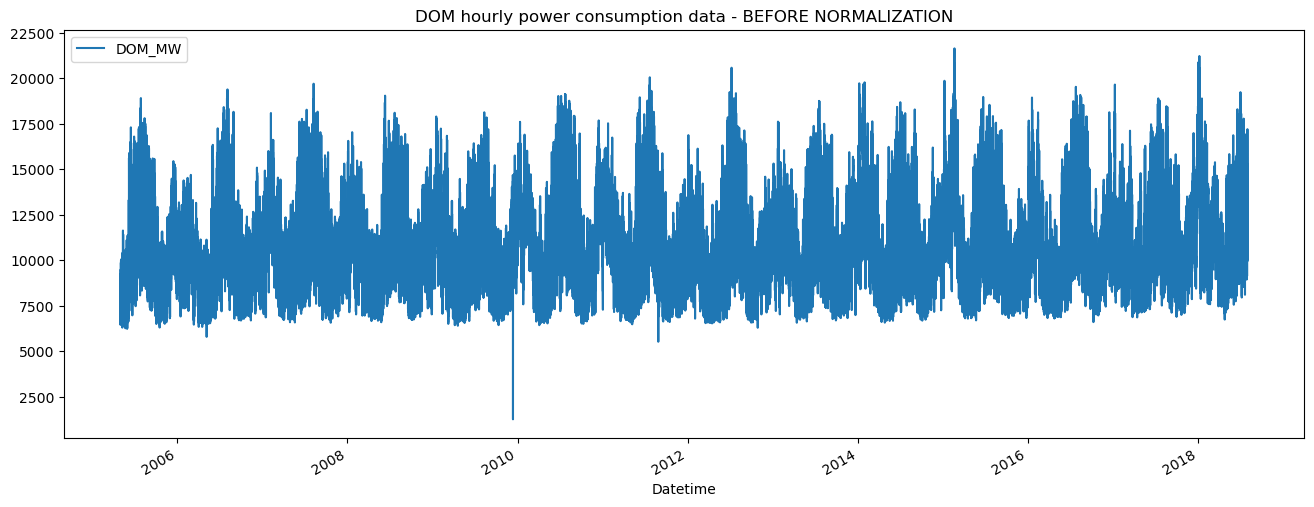

In [11]:
df.plot(figsize=(16,6),legend=True)

plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

- **Normalize data**
- Normalizing data using MinMaxScaler. 


In [12]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['DOM_MW']=scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(116189, 1)

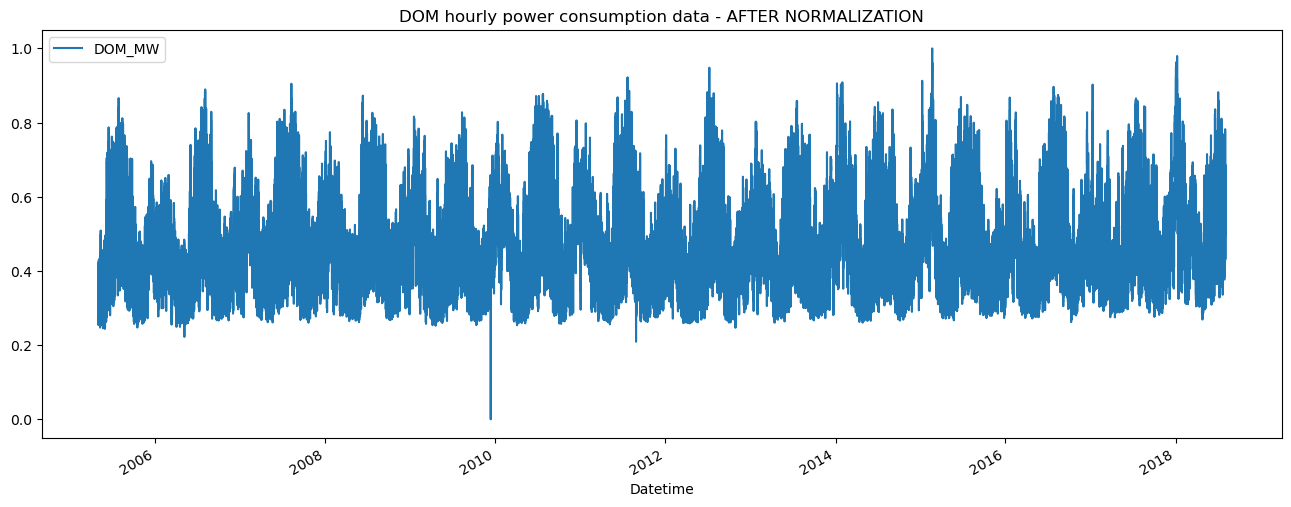

In [14]:
df_norm.plot(figsize=(16,6),legend=True)

plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

plt.show()

In [15]:
df_norm.shape

(116189, 1)

## 3. Prepare data for training the RNN models

In [16]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[110000:]             
    y_test = y_train[110000:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [17]:
#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (6169, 20, 1)
y_test.shape =  (6169,)


## 4. Build a SIMPLE RNN model

In [18]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 dropout (Dropout)           (None, 20, 40)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 40)            3240      
                                                                 
 dropout_1 (Dropout)         (None, 20, 40)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense (Dense)               (None, 1)                 4

In [19]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 14s 99ms/step - loss: 0.0933
Epoch 2/10
110/110 [==============================] - 16s 143ms/step - loss: 0.0149
Epoch 3/10
110/110 [==============================] - 15s 136ms/step - loss: 0.0086
Epoch 4/10
110/110 [==============================] - 12s 111ms/step - loss: 0.0062
Epoch 5/10
110/110 [==============================] - 11s 102ms/step - loss: 0.0047
Epoch 6/10
110/110 [==============================] - 11s 101ms/step - loss: 0.0038
Epoch 7/10
110/110 [==============================] - 11s 103ms/step - loss: 0.0032
Epoch 8/10
110/110 [==============================] - 11s 102ms/step - loss: 0.0028
Epoch 9/10
110/110 [==============================] - 11s 103ms/step - loss: 0.0025
Epoch 10/10
110/110 [==============================] - 11s 102ms/step - loss: 0.0022


- **Let's check r2 score for the values predicted by the above trained SIMPLE RNN model**

In [20]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

193/193 [==============================] - 1s 4ms/step
R2 Score of RNN model =  0.9461918539390889


- **Compare the actual values vs predicted values by plotting a graph**


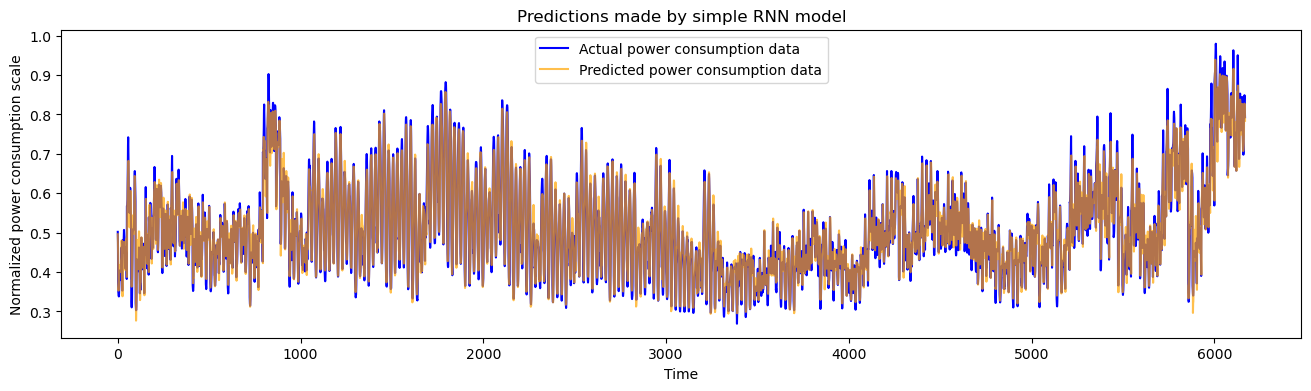

In [21]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

## 5. Build an LSTM model

In [22]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 40)            6720      
                                                                 
 dropout_3 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 40)            12960     
                                                                 
 dropout_4 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_5 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [23]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 37s 290ms/step - loss: 0.0218
Epoch 2/10
110/110 [==============================] - 29s 263ms/step - loss: 0.0105
Epoch 3/10
110/110 [==============================] - 29s 263ms/step - loss: 0.0057
Epoch 4/10
110/110 [==============================] - 27s 241ms/step - loss: 0.0043
Epoch 5/10
110/110 [==============================] - 27s 247ms/step - loss: 0.0035
Epoch 6/10
110/110 [==============================] - 28s 256ms/step - loss: 0.0028
Epoch 7/10
110/110 [==============================] - 31s 279ms/step - loss: 0.0023
Epoch 8/10
110/110 [==============================] - 29s 266ms/step - loss: 0.0020
Epoch 9/10
110/110 [==============================] - 29s 266ms/step - loss: 0.0018
Epoch 10/10
110/110 [==============================] - 27s 249ms/step - loss: 0.0017


- **Let's check r2 score for the values predicted by the above trained LSTM model**

In [24]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

193/193 [==============================] - 4s 13ms/step
R^2 Score of LSTM model =  0.9561745154358128


- **Let's compare the actual values vs predicted values by plotting a graph**

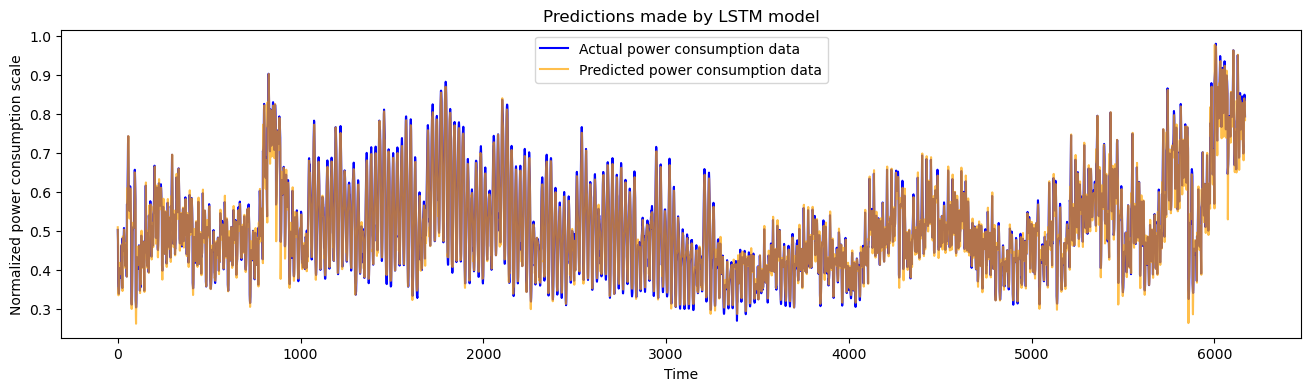

In [25]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

## 6. Compare predictions made by simple RNN, LSTM model by plotting data in a single graph

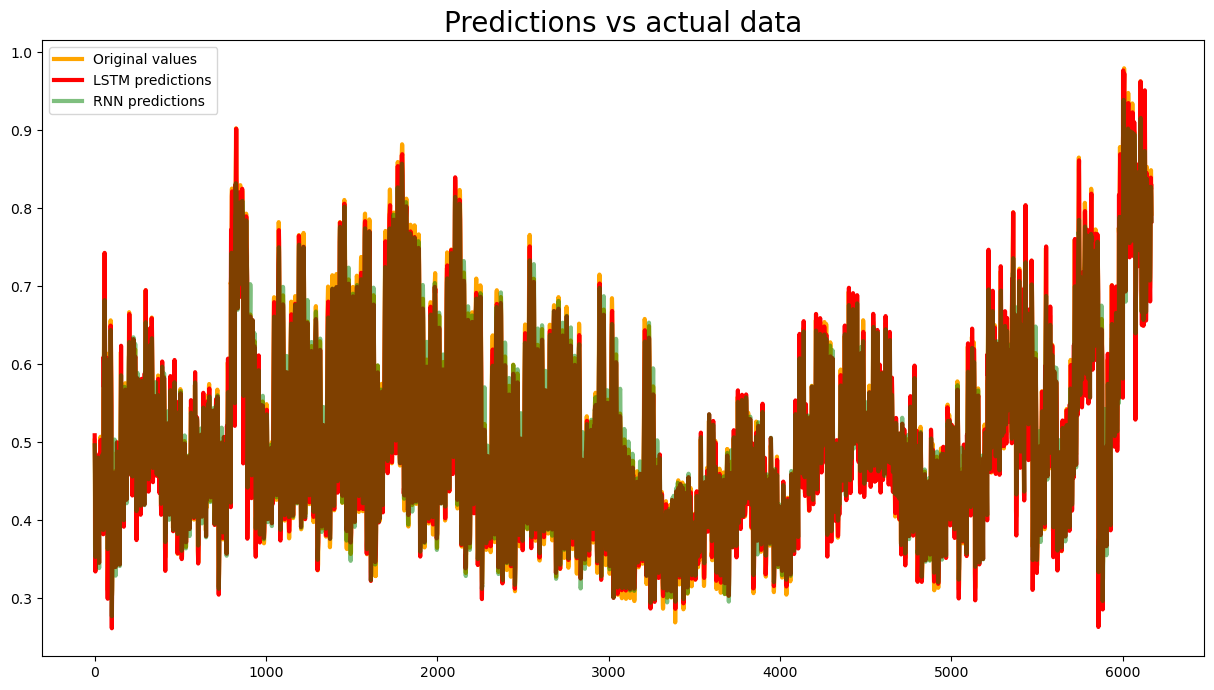

In [26]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="green", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()